In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin-price-dataset/BTC_ALL_graph_coinmarketcap.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
data = pd.read_csv('/kaggle/input/bitcoin-price-dataset/BTC_ALL_graph_coinmarketcap.csv', delimiter=';')

In [4]:
data = data[['open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']]

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [6]:
data['timestamp']

0     2010-07-13 00:00:00+00:00
1     2010-07-19 00:00:00+00:00
2     2010-07-25 00:00:00+00:00
3     2010-08-01 00:00:00+00:00
4     2010-08-07 00:00:00+00:00
                 ...           
726   2023-04-23 00:00:00+00:00
727   2023-04-30 00:00:00+00:00
728   2023-05-06 00:00:00+00:00
729   2023-05-13 00:00:00+00:00
730   2023-05-19 00:00:00+00:00
Name: timestamp, Length: 731, dtype: datetime64[ns, UTC]

In [7]:
data = data.sort_values('timestamp')

In [8]:
prices = data['close'].values.reshape(-1, 1)

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)

In [10]:
train_size = int(len(prices_scaled) * 0.8)
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size:]

In [11]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

In [12]:
sequence_length = 30

In [13]:
X_train, y_train = create_sequences(train_data, sequence_length)

In [14]:
X_test, y_test = create_sequences(test_data, sequence_length)


In [15]:
model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    layers.LSTM(64),
    layers.Dense(1)
])

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')


In [17]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [18]:
predictions = model.predict(X_test)

4/4 [==============================] - 1s 12ms/step


In [19]:
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

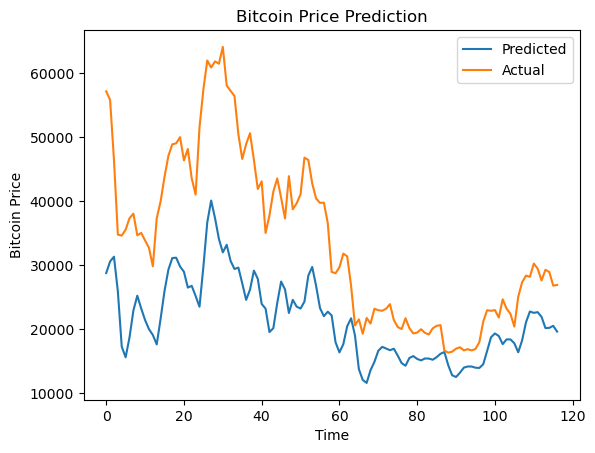

In [20]:
plt.plot(predictions, label='Predicted')
plt.plot(y_test, label='Actual')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

In [21]:
last_timestamp = data['timestamp'].iloc[-1]
future_timestamps = pd.date_range(last_timestamp + pd.DateOffset(days=1), periods=31, freq='D')


In [22]:
future_input = prices_scaled[-sequence_length:].reshape(1, -1, 1)
future_predictions = []

In [23]:
for _ in range(len(future_timestamps)):
    future_prediction = model.predict(future_input)[0][0]
    future_predictions.append(future_prediction)
    future_prediction_reshaped = future_prediction.reshape(1, 1, 1)
    future_input = np.append(future_input[:, 1:, :], future_prediction_reshaped, axis=1)


1/1 [==============================] - 0s 37ms/step


In [24]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

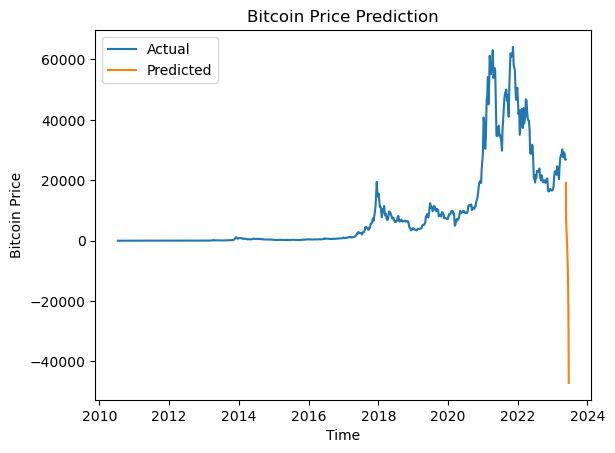

In [25]:
plt.plot(data['timestamp'], prices, label='Actual')
plt.plot(future_timestamps[:len(future_predictions)], np.squeeze(future_predictions), label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

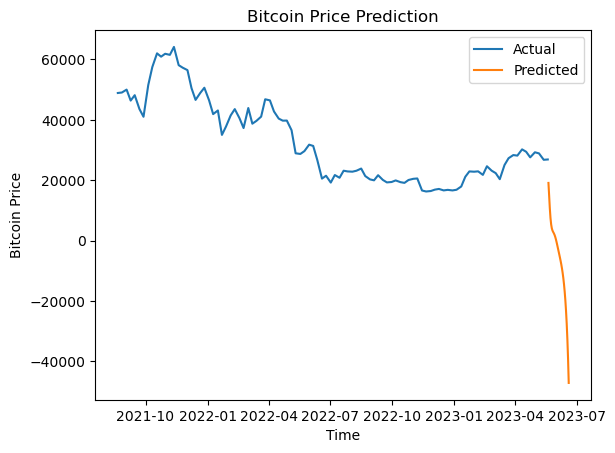

In [26]:
plt.plot(data['timestamp'][-100:], prices[-100:], label='Actual')  # Plot only the last 100 timestamps
plt.plot(future_timestamps, future_predictions[:len(future_timestamps)], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

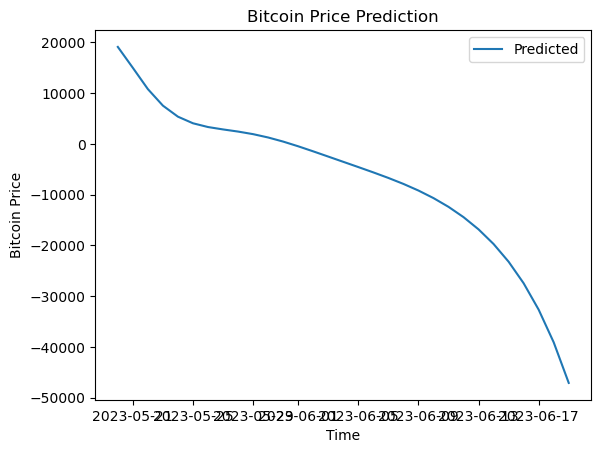

In [27]:
plt.plot(future_timestamps, future_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

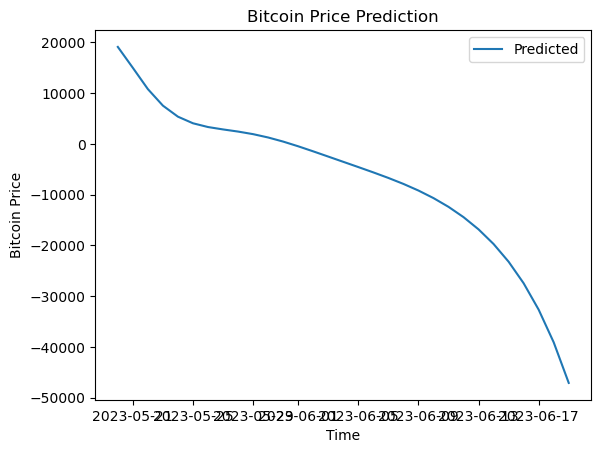

In [28]:
plt.plot(future_timestamps[:len(future_predictions)], future_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

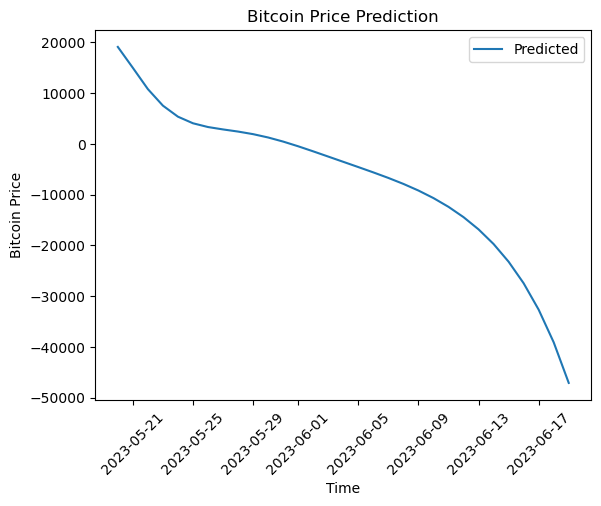

In [29]:
plt.plot(future_timestamps[:len(future_predictions)], future_predictions[:len(future_timestamps)], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xticks(rotation=45)
plt.legend()
plt.show()

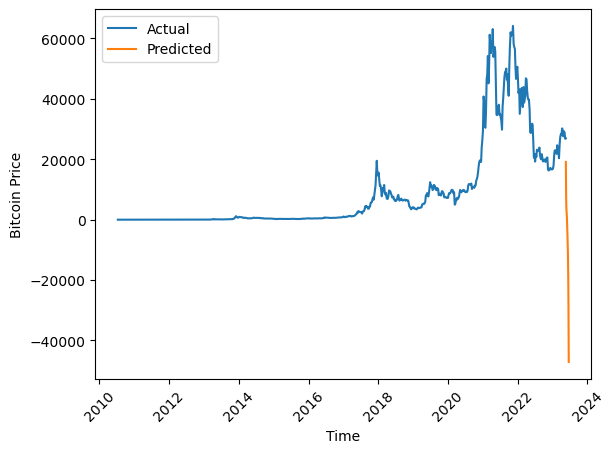

In [30]:
plt.plot(data['timestamp'], prices, label='Actual')
plt.plot(future_timestamps, future_predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()